### Analyze the training dataset annotations, and check for potential wrong annotations.
### 检查数据集中的错误命名的标签，并将其纠正。

In [2]:
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import math

classes = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','opcar','cover',"basket"]

# 将某文件夹中的所有xml旋转目标标注文件中的class类别读取出来，保存在一个字符串集合里；
# 若某类别名称不在指定列表中，则单独保存
# 返回所有类别名称以及不在指定列表中的类别名称
def collect_class_names(classes, dir_path):
    class_names = set()
    new_cls_names = set()
    out_file = open('wrong_labels.txt', 'w')
    wrong_files = set()
    for in_file in os.listdir(dir_path):
        # start parsing the xml file and extract the bbox information
        in_file_path = os.path.join(dir_path, in_file)
        # print(in_file_path)
        in_file = open(in_file_path)
        tree = ET.parse(in_file)
        root = tree.getroot()

        # enumerate all objects (bboxes) in the xml file
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            # get class index
            cls = obj.find('name').text
            class_names.add(cls)
            if cls not in classes:
                new_cls_names.add(cls)
                out_file.write(in_file_path+'\n')
                wrong_files.add(in_file)
            # cls_id = classes.index(cls)
    return list(class_names), list(new_cls_names), list(wrong_files)

# dir_path = "DOTA_demo_view/dianli_datasets/full_classes/newdataset/electricity-annotations-11.3/"
# names, wrong_names, wrong_files = collect_class_names(classes, dir_path)
# print(names)
# print(wrong_names)
# print(wrong_files)


In [22]:
print(round(2.6))
print(round(3.1))

3
3


### 将XML标记转换为YOLO TXT标记；注意旋转框的格式！

In [3]:
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import math

classes = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','opcar','cover',"basket"]

# 将某文件夹中的所有xml旋转目标标注文件中的class类别读取出来，保存在一个字符串集合里；
# 若某类别名称不在指定列表中，则单独保存
# 返回所有类别名称以及不在指定列表中的类别名称
def collect_class_names(classes, dir_path):
    class_names = set()
    new_cls_names = set()
    out_file = open('wrong_labels.txt', 'w')
    for in_file in os.listdir(dir_path):
        # start parsing the xml file and extract the bbox information
        in_file_path = os.path.join(dir_path, in_file)
        # print(in_file_path)
        in_file = open(in_file_path)
        tree = ET.parse(in_file)
        root = tree.getroot()

        # enumerate all objects (bboxes) in the xml file
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            # get class index
            cls = obj.find('name').text
            class_names.add(cls)
            if cls not in classes:
                new_cls_names.add(cls)
                out_file.write(in_file_path+'\n')
            # cls_id = classes.index(cls)
    return list(class_names), list(new_cls_names)

# dir_path = "DOTA_demo_view/dianli_datasets/labels/"
# names, wrong_names = collect_class_names(classes, dir_path)

# 根据wrong_names手工设置wrong_classes字典
wrong_classes = {'clothes ': 'clothes', 'opeartingbar': 'operatingbar', 'operatingar': 'operatingbar', 'operatingbar ':'operatingbar', 'operatingbar  ':'operatingbar', 'operatingbar   ':'operatingbar', 'weongglove': 'wrongglove'}

# 根据wrong_classes生成正确的YOLO标记文件
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import math
import numpy as np
import cv2 as cv

def RoVOCToPoly(xc_n, yc_n, w_n, h_n, W, H, theta1):
    xc = xc_n * W
    yc = yc_n * H
    w = w_n * W
    h = h_n * H
    # 1. calculate the angle theta2
    L = math.sqrt(w**2 + h**2)
    # print("L:    "+str(L))
    # print("w:    "+str(w))
    # print("h:    "+str(h))
    theta2 = math.degrees(math.atan(h/w))
    theta = theta1 + theta2
    # print(f"theta1:{theta1}")
    # print(f"theta2:{theta2}")
    # print(str(theta))
    # 2. calculate (x1, y1)
    # print(str(L/2))
    dx1 = (L/2) * math.cos(math.radians(theta))
    dy1 = (L/2) * math.sin(math.radians(theta))
    # print("dx1an:"+str(math.cos(math.radians(theta))))
    # print("x1xc :"+str(dx1))
    x1 = xc + dx1
    y1 = yc + dy1
    # 3. calculate (x3, y3)
    x3 = xc - dx1
    y3 = yc - dy1
    # 4. calculate (x2, y2)
    dx2 = h * math.cos(math.radians(90 - theta1))
    dy2 = h * math.sin(math.radians(90 - theta1))
    x2 = x1 + dx2
    y2 = y1 - dy2
    # 5. calculate (x4, y4)
    dx4 = w * math.cos(math.radians(theta1))
    dy4 = w * math.sin(math.radians(theta1))
    x4 = x1 - dx4
    y4 = y1 - dy4
    # print(f"x1:{x1}")
    return x1, y1, x2, y2, x3, y3, x4, y4

# 输入：逆时针排序的四个点，Poly格式； 
# 返回：右下，左下，右上,左上；
# 427 288 344 287 344 155 427 156
def sort_points(x1,y1,x2,y2,x3,y3,x4,y4):
    p1, p2, p3, p4 = sorted([(x1,y1),(x2,y2),(x3,y3),(x4,y4)], key=lambda x:(x[1], x[0]), reverse=True)
    print(f"sorted:{p1,p2,p3,p4}")
    # [(427, 288), (344, 287), (427, 156), (344, 155)]
    if(p1[0] < p2[0]):
        t=p1
        p1=p2
        p2=t
    if(p3[0] < p4[0]):
        t=p3
        p3=p4
        p4=t
    return p1,p2,p3,p4

# calculate angle w.r.t. the long side
# sorted([(427, 288), (427, 156), (344, 287), (344, 155)],key=lambda x:(x[1], x[0]), reverse=True)
def LongSideTheta(sorted_points):
    # ll: lower-left, lr: lower-right, ul: upper-left, ur: upper-right
    # ll is the lowest point
    (lrx,lry),(llx,lly),(urx,ury),(ulx,uly) = sorted_points
    # 0. check if the box is horizontal;
    # print(f"lly:{lly},lry:{lry},lly==lry:{lly==lry}")
    if (lly == lry or urx == lrx):
        w = lrx - llx
        h = lry - ury
        if w < h:
            return 90
        else:
            return 0
    # 1. calculate length of 1-2 and 2-3, find out which is the long side.
    l1_2 = math.sqrt((lrx-llx)**2 + (lry-lly)**2) # length of ll-lr
    l2_3 = math.sqrt((urx-lrx)**2 + (ury-lry)**2) # length of lr-ur
    # print(f"l1_2:{l1_2}, l2_3:{l2_3}")
    # calculate theta regarding the long side:
    if (l1_2 > l2_3): # less than 90 degrees
        return math.degrees(math.atan((lly-lry)/(lrx-llx)))
    else: # 90-180 degrees
        return 180 - math.degrees(math.atan((lry-ury)/(lrx-urx)))
    
    # if (lry > lly): # less than 90 degrees
    #     return math.degrees(math.atan((lry-ury)/(urx-lrx)))
    # else: # 90-180 degrees
    #     return 180 - math.degrees(math.atan((lry-ury)/(lrx-urx)))



# !!!! updated long side theta function, should use this one!
# calculate long-side theta
# 1. find out which side is the longest;
# 2. calculate the angle theta
def LongSideThetaNP(x1,y1,x2,y2,x3,y3,x4,y4):
    l1=round((y2-y1)**2+(x2-x1)**2)
    l2=round((y3-y4)**2+(x3-x4)**2)
    # print(f"l1:{l1}")
    # print(f"l2:{l2}")
    assert(int(l1)==int(l2))
    l_12 = math.sqrt((y2-y1)**2+(x2-x1)**2)
    l_23 = math.sqrt((y3-y2)**2+(x3-x2)**2)
    L = math.sqrt((y3-y1)**2+(x3-x1)**2)
    if(l_12 >= l_23): # p1-p2 is the long side
        p1,p2=sorted([(x1,y1),(x2,y2)])    
    else:
        p1,p2=sorted([(x2,y2),(x3,y3)])
    if(p1[1]==p2[1]):
        return 0
    elif (p1[0]==p2[0]):
        return 90
    else:
        # print((p1[1]-p2[1])/L)
        angle = math.degrees(math.asin((p1[1]-p2[1])/L))
        if (angle < 0):
            angle = angle + 180
        return angle


# 读取XML标记文件并转换为YOLO格式；
# convert XML style rotated label to YOLO style label
# input:
#  size: the width and height of the input image
#  box: the upper-left and lower-right points of the bbox
# 注意：
# 1. roLabelImage的XML标记格式中，角度并不一定匹配长边法！若不加以验证则可能导致训练失败！
# 2. roLabelImage的XML标记格式中，W, H有可能是颠倒的！
def convert_robox(size, box):
    # compute the normalized factors
    dw = 1./(size[0])
    dh = 1./(size[1])
    # get the x,y,w,h in pixels
    cx = box[0]*dw
    cy = box[1]*dh
    w = box[2]
    h = box[3]
    # 注意！roLabelImg表示法与长边表示法不同，w,h可能是颠倒的！
    ww = max(w, h)*dw
    hh = min(w, h)*dh
    a = math.degrees(box[4])
    # 首先将roLabelImg格式转换为四点Poly表示法
    x1,y1,x2,y2,x3,y3,x4,y4 = RoVOCToPoly(cx, cy, w*dw, h*dh, size[0], size[1], a)
    # 之后将Poly表示法换算为长边表示法
    # sorted_points = sort_points(x1,y1,x2,y2,x3,y3,x4,y4)
    ## print(sorted_points)
    ## a = LongSideTheta(sorted_points)
    a = LongSideThetaNP(x1,y1,x2,y2,x3,y3,x4,y4)
    return (cx,cy,ww,hh,int(a))
    # return x1,y1,x2,y2,x3,y3,x4,y4

# input:
#  size: the width and height of the input image
#  box: the upper-left and lower-right points of the bbox
def convert_bbox(size, box):
    # compute the normalized factors
    dw = 1./(size[0])
    dh = 1./(size[1])
    # compute the center of the bbox
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    # compute the width and height of the bbox
    w = box[1] - box[0]
    h = box[3] - box[2]
    # normalize the numbers
    x = x*dw
    ww = max(w, h)*dw
    y = y*dh
    hh = min(w, h)*dh
    a = 0 if w>h else 90
    return (x,y,ww,hh,a)


def DrawPoly(img, x1, y1, x2, y2, x3, y3, x4, y4):
    H, W, C = img.shape 
    pts = np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv.polylines(img,[pts],True,(0,255,0))

# 将指定文件夹下的XML标记文件转换为YOLO格式文件；
# classes：指定标准类别
# ignored_cls: 忽略类别；（对于数量非常少的目标可以将其忽略，以平衡数据集各目标种类）
# dir_path: xml文件所在的文件夹路径
# output_path: yolo标记文件输出路径
# image_path: xml对应的图像文件所在路径；(使用此路径，可检查是否所有图像都对应一个标记文件；也可将其设置为xml文件所在路径，从而忽略此检查)
def convert_xml_to_yolo(classes, ignored_cls, dir_path, output_path, image_path):
    # e.g. if imagepath='./test.jpg', then basename_no_ext='test'
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]
    print(basename)
    img = cv.imread("./DOTA_demo_view/dianli_datasets/full_classes/newdataset/electricity-image-11.3/"+basename_no_ext+".jpg")

    # locate the corresponding xml annotation file of the image
    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    # set the output of the yolo annotation file
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    # start parsing the xml file and extract the bbox information
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    max_a = 0
    # enumerate all objects (bboxes) in the xml file
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        # get class index
        cls = obj.find('name').text
        if cls not in classes:
            # if the cls is a wrong label, change it to the correct label!
            cls = wrong_classes[cls]
        if cls in ignored_cls:
            continue
        cls_id = classes.index(cls)
        # get the corner coordinates and convert to yolo format
        xmlrbox = obj.find('robndbox')
        if (xmlrbox!=None):
            b = (float(xmlrbox.find('cx').text), float(xmlrbox.find('cy').text), float(xmlrbox.find('w').text), float(xmlrbox.find('h').text), float(xmlrbox.find('angle').text))
            if(max_a < b[4]):
                max_a = b[4]
            bb = convert_robox((w,h), b)
            # x1,y1,x2,y2,x3,y3,x4,y4 = convert_robox((w,h), b)
            # DrawPoly(img,x1,y1,x2,y2,x3,y3,x4,y4)
            # finally write the "cls x y w h" as a single line into the yolo annotaiton file
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
        xmlbox = obj.find('bndbox')
        if (xmlbox!=None):
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert_bbox((w,h), b)
            # finally write the "cls x y w h" as a single line into the yolo annotaiton file
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
    # cv.imwrite("./DOTA_demo_view/dianli_datasets/"+"out.jpg", img)
    return max_a


def getXMLsInDir(dir_path):
    xml_list = []
    for filename in glob.glob(dir_path + '/*.xml'):
        xml_list.append(filename)
    return xml_list

dir_path = "DOTA_demo_view/dianli_datasets/full_classes/newdataset/electricity-annotations-11.3"
xml_path = "DOTA_demo_view/dianli_datasets/full_classes/newdataset/electricity-annotations-11.3"
output_path = "DOTA_demo_view/dianli_datasets/full_classes/newdataset/yolo_labels/"
# # dir_path = "DOTA_demo_view/dianli_datasets/operatingbars/newsamples_labels/"
# # xml_path = dir_path
# # output_path = "DOTA_demo_view/dianli_datasets/operatingbars/train/labels/"
# # if the output directory does not exists, we should create it
# if not os.path.exists(output_path):
#     os.makedirs(output_path)


xml_paths = getXMLsInDir(xml_path)
wrong_classes = {'\\':'head'}
classes = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','opcar','cover',"basket"]
# wrong_classes = {'clothes ': 'clothes', 'opeartingbar': 'operatingbar', 'operatingar': 'operatingbar', 'operatingbar ':'operatingbar', 'operatingbar  ':'operatingbar', 'operatingbar   ':'operatingbar', 'weongglove': 'wrongglove'}
# classes = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','powerchecker','badge']
# # ignored_cls = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','powerchecker','badge']
ignored_cls = ['powerchecker','badge']
# # classes = ['operatingbar']
# # ignored_cls = []

# xml_path = "DOTA_demo_view/dianli_datasets/ull_classes/newdataset/electricity-annotations-11.3/DJI_0040-220000000214.xml"
# convert_xml_to_yolo(classes, ignored_cls, dir_path, output_path, xml_path)
# max_ang = 0
# for xml_path in xml_paths:
#     # print(xml_path)
#     angle = convert_xml_to_yolo(classes, ignored_cls, dir_path, output_path, xml_path)
#     if (max_ang < angle):
#         max_ang = angle

# print(max_ang)


In [8]:
sorted([(427, 288), (427, 156), (344, 287), (344, 155)],key=lambda x:(x[1], x[0]), reverse=True)

[(427, 288), (344, 287), (427, 156), (344, 155)]

### 创建只包含operatingbar的数据集；针对现有YOLO标记，进行过滤

In [2]:
# 过滤掉don't care类别
def get_basename(full_path):
    basename = os.path.basename(full_path)
    basename_no_ext = os.path.splitext(basename)[0]
    return basename_no_ext

def generate_filtered_labels(dir_path, names, ignored_cls, output_path):
    for in_file in os.listdir(dir_path):
        in_file_path = os.path.join(dir_path, in_file)
        # print(in_file_path)
        in_file = open(in_file_path)
        basename = get_basename(in_file_path)
        out_file = open(output_path + basename + '.txt', 'w')
        # enumerate all objects (bboxes) in the txt file
        for line in in_file.readlines():
            line_split = line.split()
            # get class index
            cls_id = int(line_split[0])
            if(names[cls_id] not in ignored_cls):
                out_file.write(line.replace(line_split[0], "0", 1))

dir_path = "DOTA_demo_view/dianli_datasets/operatingbars/train4/labels/"
output_path = "DOTA_demo_view/dianli_datasets/operatingbars/train4/labels2/"
classes = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','powerchecker','badge']
ignored_cls = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','powerchecker','badge']
# generate_filtered_labels(dir_path, classes, ignored_cls, output_path)


### plot the labels histogram--画所有标签数量的直方图

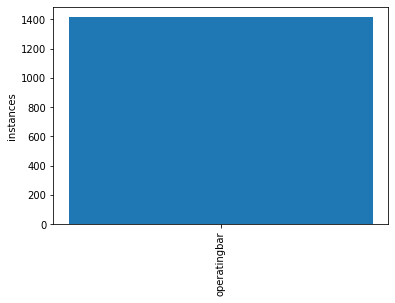

max_ratio:127.32601580891253,min_ratio:1.0416666666666623


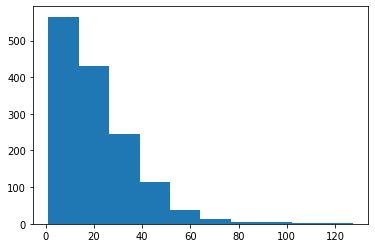

In [4]:
from pathlib import Path

# 遍历所有YOLO标记文件，并采集所有标签到一个numpy列表
def collect_labels(dir_path):
    labels = []
    ratios = []
    for in_file in os.listdir(dir_path):
        # start parsing the yolo txt file and extract the bbox information
        in_file_path = os.path.join(dir_path, in_file)
        # print(in_file_path)
        in_file = open(in_file_path)
        # enumerate all objects (bboxes) in the txt file
        for line in in_file.readlines():
            line = line.split()
            # get class index
            cls_id = int(line[0])
            w = float(line[3])
            h = float(line[4])
            labels.append(cls_id)
            ratios.append(max(w/(h+1e-16), h/(w+1e-16)))
    return labels, ratios

import matplotlib.pyplot as plt
import numpy as np
def plot_labels(labels, names=(), save_dir=Path(''), loggers=None):
    # 1. labels should be a list of numbers;
    fig, ax = plt.subplots()
    ax.set_ylabel('instances')
    nc = len(names)
    ax.set_xticks(range(nc))
    ax.set_xticklabels(names, rotation=90, fontsize=10)
    plt.hist(labels,bins=np.linspace(0, nc, nc + 1) - 0.5, rwidth=0.8)
    plt.show()

# dir_path = "DOTA_demo_view/dianli_datasets/yolo_labels/"
dst_txt_dir = "./DOTA_demo_view/dianli_datasets/train2/labels/"
labels,ratios = collect_labels(dst_txt_dir)
max_ratio = np.amax(np.array(ratios))
min_ratio = np.amin(np.array(ratios))
# names = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar'] 
names = ['operatingbar'] 
# plot_labels(labels, names)
print(f"max_ratio:{max_ratio},min_ratio:{min_ratio}")
print(ratios)

def plot_aspect_ratio(ratios):
    plt.hist(ratios)
    plt.show()

# plot_aspect_ratio(ratios)

### 选取操作杆图片，并将标记图片显示在tensorboard以供检查

In [24]:
# 得到operatingbar标签类别对应的id
# names = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar']
names = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','opcar','cover',"basket"]

# names = ['operatingbar'] 
class_id = names.index("person")

# 将某路径下所有包含某类型(如操作杆)的txt标记文件全部找出，并保存到列表中。
def collect_specified_txts(dir_path, class_id):
    labels = set()
    for in_file in os.listdir(dir_path):
        # start parsing the yolo txt file and extract the bbox information
        in_file_path = os.path.join(dir_path, in_file)
        # print(in_file_path)
        in_file = open(in_file_path)
        # enumerate all objects (bboxes) in the txt file
        for line in in_file.readlines():
            line = line.split()
            # get class index
            cls_id = int(line[0])
            if(cls_id == class_id):
                labels.add(in_file_path)
    return list(labels)  

dir_path = "DOTA_demo_view/dianli_datasets/full_classes/newdataset/yolo_labels/"
txt_paths = collect_specified_txts(dir_path, class_id)
len(txt_paths)



1560

In [2]:
# 以下实现将转换完毕的标注文件可视化并在tensorboard中显示
# 注意，执行本代码段之前需要执行上一步代码段生成txt_paths标注文件列表

import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import math
import cv2 as cv
from utils.plot import GetLabels, VisualizeLabelsNP

def get_basename(full_path):
    basename = os.path.basename(full_path)
    basename_no_ext = os.path.splitext(basename)[0]
    return basename_no_ext

# 从文件夹中提取全部后缀为suffix的文件完整路径列表
def getSuffixedFilesInDir(dir_path, suffix):
    flist = []
    for filename in glob.glob(dir_path + '/*.' + suffix):
        flist.append(filename)
    return flist

from random import seed
from random import random, randint



# 遍历所有txt列表中的所有标注文件，并生成相应的图片保存到指定位置
img_output_path = "./DOTA_demo_view/dianli_datasets/"
img_input_dir = "./DOTA_demo_view/dianli_datasets/full_classes/newdataset/images/"
# txt_paths = ["./DOTA_demo_view/dianli_datasets/full_classes/newdataset/labels/DJI_0040-220000000214.txt"]
txt_dir = "./DOTA_demo_view/dianli_datasets/full_classes/newdataset/labels/"
txt_paths = getSuffixedFilesInDir(txt_dir, 'txt')

classes = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','opcar','cover',"basket"]
for txt_path in txt_paths:
    # visualize 100 images:
    rand = randint(0, 10)
    if (rand == 1):
        name = get_basename(txt_path)
        img_path = img_input_dir + name + ".jpg"
        print(img_path)
        img = cv.imread(img_path)
        labels = GetLabels(txt_path)
        VisualizeLabelsNP(img, labels, classes, name, img_output_path)

KeyboardInterrupt: 

In [5]:
h=0.035
w=0.339
math.degrees(math.atan(h/w))

5.894608147035543

In [10]:
# 将生成的可视化标注图片以5x5的格式展示到tensorboard中
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("tensorboard/check_newdatasets")

import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import make_grid

from random import seed
from random import random, randint

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.png'):
        image_list.append(filename)
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)
    return image_list
    
img_dir = "./DOTA_demo_view/dianli_datasets/gt_visualization/"
img_paths = getImagesInDir(img_dir)
imgs = []
count = 0
batch_id = 0
seed(1)
for img_path in img_paths:
    # randomly pick the image to show; rate is 1/10
    rand = randint(0, 10)
    if (rand == 1):
        if count==25:
            grid = make_grid(imgs)
            writer.add_image('helmet_images', grid, batch_id)
            print(f"generating {batch_id}th image grid...")
            count = 0
            batch_id += 1
            imgs = []
        img = read_image(img_path)
        imgs.append(img)
        count +=1


generating 0th image grid...
generating 1th image grid...
generating 2th image grid...
generating 3th image grid...
generating 4th image grid...


### 创建新数据集：由所有天池杯图片以及300张随机挑选的自建数据集图片组成

In [1]:
src_img_dir = "./DOTA_demo_view/dianli_datasets/train/images/"
src_txt_dir = "./DOTA_demo_view/dianli_datasets/train/labels/"
dst_img_dir = "./DOTA_demo_view/dianli_datasets/train2/images/"
dst_txt_dir = "./DOTA_demo_view/dianli_datasets/train2/labels/"

# 从源文件夹随机挑选300张图片和对应的标签，拷贝到目标文件夹
NO_IMGS = 300
# 首先建立三百张图片的路径列表
def select_rand_imgs(src_img_dir):
    seed(10)
    img_lst = []
    for file in os.listdir(src_img_dir):
        if file.startswith("img"):
            rand = randint(0, 10)
            # print(src_img_dir+file)
            if(rand==1):
                img_lst.append(src_img_dir+file)
    return img_lst


# img_lst = (select_rand_imgs(src_img_dir))

import shutil
# 将列表中指定的图片以及对应的标记拷贝到目标文件夹
def create_dataset_from_list(src_img_lst, src_txt_dir, dst_img_dir, dst_txt_dir, suffix):
    for img_path in src_img_lst:
        shutil.copy(img_path, dst_img_dir)
        # get corresponding .txt path:
        basename = os.path.basename(img_path)
        basename_no_ext = os.path.splitext(basename)[0]
        txt_path = src_txt_dir + basename_no_ext + suffix
        shutil.copy(txt_path, dst_txt_dir)

# create_dataset_from_list(img_lst, src_txt_dir, dst_img_dir, dst_txt_dir, ".txt")


In [25]:
!cp ./DOTA_demo_view/dianli_datasets/yolo_labels/*.txt ./DOTA_demo_view/dianli_datasets/train2/labels/

In [33]:
# 将天池杯所有标签对应的图片拷贝到新训练集文件夹
txt_dir = "./DOTA_demo_view/dianli_datasets/yolo_labels/"
def select_tianchi_imgs(txt_dir):
    txt_lst = []
    for file in os.listdir(txt_dir):
        if not file.startswith("img"):
            txt_lst.append(txt_dir+file)
    return txt_lst

# 得到所有天池杯图片txt标签文件列表
tianchi_list = select_tianchi_imgs(txt_dir)

# 将对应图片与标签拷贝到目标文件夹
create_dataset_from_list(tianchi_list, src_img_dir, dst_txt_dir, dst_img_dir, ".jpg")

In [38]:
!python train2.py --weights=./weights/yolov5s.pt --multi-scale --device=1,4,5 --batch-size=84

Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)
           device1 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)
           device2 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)

Namespace(adam=False, batch_size=84, bucket='', cache_images=False, cfg='./models/yolov5m.yaml', data='data/secure_check.yaml', device='1,4,5', epochs=50, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, logdir='runs/', multi_scale=True, name='', noautoanchor=False, nosave=False, notest=True, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=84, weights='./weights/yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, '

### 创建新数据集-根据两段视频解析出的图像，采集共约1000张图片;将图片调整为正方形，方便以正方形尺片进行训练

In [2]:
# 将生成的可视化标注图片以4x4的格式展示到tensorboard中
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("tensorboard/check_opbars")

import glob
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import make_grid

from random import seed
from random import random, randint
import shutil

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.png'):
        image_list.append(filename)
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)
    return image_list
    
src_dir = "./DOTA_demo_view/dianli_datasets/raw_imgs/dj/newimgs/"
dst_dir = "./DOTA_demo_view/dianli_datasets/raw_imgs/newimgs/"
img_paths = getImagesInDir(src_dir)

import cv2
import os
img = cv2.imread('./DOTA_demo_view/dianli_datasets/raw_imgs/dj/newimgs/DJI_0039-210000000001.jpg', cv2.IMREAD_UNCHANGED)
width = img.shape[0]
height = img.shape[0] # keep original height
new_width = min(width, height)
dim = (new_width, new_width)

# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

seed(1)
for img_path in img_paths:
    # randomly pick the image to show; rate is 1/10
    #rand = randint(0, 1457)
    #if (rand <= 450):
    basename = os.path.basename(img_path)
    basename_no_ext = os.path.splitext(basename)[0]
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    width = img.shape[0]
    height = img.shape[0] # keep original height
    new_width = min(width, height)
    dim = (new_width, new_width)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(dst_dir+basename_no_ext+".jpg", resized)
    # shutil.copy(img_path, dst_dir)


### 创建数据集--full classes中除掉天池数据，只保留自建

In [2]:
# 将所有自建数据集的标签对应的图片拷贝到新训练集文件夹
img_dir = "./DOTA_demo_view/dianli_datasets/full_classes/train/images/"
src_txt_dir = "./DOTA_demo_view/dianli_datasets/full_classes/train/labels/"
dst_img_dir = "./DOTA_demo_view/dianli_datasets/full_classes/train2/images/"
dst_txt_dir = "./DOTA_demo_view/dianli_datasets/full_classes/train2/labels/"

def select_custom_imgs(txt_dir):
    txt_lst = []
    for file in os.listdir(txt_dir):
        if file.startswith("img"):
            txt_lst.append(txt_dir+file)
    return txt_lst

# 得到所有自建图片文件列表
custom_list = select_custom_imgs(img_dir)

# 将对应图片与标签拷贝到目标文件夹(src_img_lst, src_txt_dir, dst_img_dir, dst_txt_dir, suffix):
create_dataset_from_list(custom_list, src_txt_dir, dst_img_dir, dst_txt_dir, ".txt")

NameError: name 'txt_dir' is not defined

### 调整图片为正方形，并调整相应的标签

In [2]:
import cv2
 
img = cv2.imread('./DOTA_demo_view/dianli_datasets/operatingbars/train/images/record1-210000000007.jpg', cv2.IMREAD_UNCHANGED)
 
print('Original Dimensions : ',img.shape)
 
width = img.shape[0]
height = img.shape[0] # keep original height
new_width = min(width, height)
dim = (new_width, new_width)
 
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
cv2.imwrite("./DOTA_demo_view/dianli_datasets/gt_visualization/out.jpg", resized)

Original Dimensions :  (1080, 1920, 3)
Resized Dimensions :  (1080, 1080, 3)


True

In [2]:
# 调整图片为正方形之后，一并调整标签并显示可视化效果
import math
import numpy as np
import cv2

# 输入：逆时针排序的四个点，Poly格式； 
# 返回：左下，右下，左上，右上；左下点为最低点
# 若边框为水平框，则顺序只保证下-上；
# 427 288 344 287 344 155 427 156
# def sort_points(x1,y1,x2,y2,x3,y3,x4,y4):
#     p1, p2, p3, p4 = sorted([(x1,y1),(x2,y2),(x3,y3),(x4,y4)], key=lambda x:(x[1], x[0]), reverse=True)
#     # print(f"sorted:{p1,p2,p3,p4}")
#     # [(427, 288), (344, 287), (427, 156), (344, 155)]
#     if(p1[1]!=p2[1]):
#         if (p2[0]>=p3[0]):
#             return p1,p2,p3,p4
#         else:
#             return p1,p3,p2,p4
#     else:
#         return p1,p2,p3,p4
def sort_points(x1,y1,x2,y2,x3,y3,x4,y4):
    p1, p2, p3, p4 = sorted([(x1,y1),(x2,y2),(x3,y3),(x4,y4)], key=lambda x:(x[1], x[0]), reverse=True)
    # print(f"sorted:{p1,p2,p3,p4}")
    # [(427, 288), (344, 287), (427, 156), (344, 155)]
    if(p1[0] < p2[0]):
        t=p1
        p1=p2
        p2=t
    if(p3[0] < p4[0]):
        t=p3
        p3=p4
        p4=t
    return p1,p2,p3,p4
# def LongSideToPoly(xc_n, yc_n, w_n, h_n, W, H, theta1):
#     xc = xc_n * W
#     yc = yc_n * H
#     w = w_n * W
#     h = h_n * H
#     # 1. calculate the angle theta2
#     L = math.sqrt(w**2 + h**2)
#     theta2 = math.degrees(math.atan(h/w))
#     theta = theta1 + theta2
#     # 2. calculate (x1, y1)
#     # print(str(L/2))
#     dx1 = (L/2) * math.cos(math.radians(theta))
#     dy1 = (L/2) * math.sin(math.radians(theta))
#     x1 = xc + dx1
#     y1 = yc + dy1
#     # 3. calculate (x3, y3)
#     x3 = xc - dx1
#     y3 = yc - dy1
#     # 4. calculate (x2, y2)
#     dx2 = h * math.cos(math.radians(90 - theta1))
#     dy2 = h * math.sin(math.radians(90 - theta1))
#     x2 = x1 + dx2
#     y2 = y1 - dy2
#     # 5. calculate (x4, y4)
#     dx4 = w * math.cos(math.radians(theta1))
#     dy4 = w * math.sin(math.radians(theta1))
#     x4 = x1 - dx4
#     y4 = y1 - dy4
#     # 6. sort the points
#     return x1, y1, x2, y2, x3, y3, x4, y4

def LongSideToPoly2(xc_n, yc_n, w_n, h_n, W, H, theta1):
    xc = xc_n * W
    yc = yc_n * H
    w = w_n * W # length of long side 
    h = h_n * H # length of short side
    # 1. calculate the angle theta2
    L = math.sqrt(w**2 + h**2)
    # print("L:    "+str(L))
    # print("w:    "+str(w))
    # print("h:    "+str(h))
    theta2 = math.degrees(math.atan(h/w))
    theta = theta1 + theta2
    # print(str(theta1))
    print(str(theta))
    # 2. calculate (x1, y1)
    # print(str(L/2))
    dx1 = (L/2) * math.cos(math.radians(theta))
    dy1 = (L/2) * math.sin(math.radians(theta))
    # print("dx1an:"+str(math.cos(math.radians(theta))))
    # print("x1xc :"+str(dx1))
    x1 = xc - dx1
    y1 = yc + dy1
    # 3. calculate (x3, y3)
    x3 = xc + dx1
    y3 = yc - dy1
    # 4. calculate (x2, y2)
    dx2 = w * math.cos(math.radians(theta1))
    dy2 = w * math.sin(math.radians(theta1))
    x2 = x1 + dx2
    y2 = y1 - dy2
    # 5. calculate (x4, y4)
    dx4 = h * math.cos(math.radians(90 - theta1))
    dy4 = h * math.sin(math.radians(90 - theta1))
    x4 = x1 - dx4
    y4 = y1 - dy4

    return x1, y1, x2, y2, x3, y3, x4, y4

# 根据新图像尺寸调整标签
def adjust_label(label, old_size, new_size):
    cls, x, y, w, h, a = label
    old_w, old_h = old_size
    new_w, new_h = new_size
    w_rate = new_w / old_w
    h_rate = new_h / old_h
    # 首先根据中心点和长宽角度换算出四个角点
    x1, y1, x2, y2, x3, y3, x4, y4 = LongSideToPoly2(x, y, w, h, old_w, old_h, a)
    x1p,x2p,x3p,x4p = x1*w_rate, x2*w_rate, x3*w_rate, x4*w_rate
    y1p,y2p,y3p,y4p = y1*h_rate, y2*h_rate, y3*h_rate, y4*h_rate
    return x1p,y1p,x2p,y2p,x3p,y3p,x4p,y4p


import cv2
def DrawSquareImg(img):
    width = img.shape[0]
    height = img.shape[0] # keep original height
    new_width = min(width, height)
    dim = (new_width, new_width)
    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return img

def WriteTxt(img, txt, org):
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX    
    # fontScale
    fontScale = 1   
    # Blue color in BGR
    color = (255, 0, 0)   
    # Line thickness of 2 px
    thickness = 2    
    # Using cv2.putText() method
    cv2.putText(img, txt, org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)

def DrawPoly(img, x1, y1, x2, y2, x3, y3, x4, y4):
    H, W, C = img.shape 
    pts = np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,(0,255,0))
    WriteTxt(img,"1",(int(x1),int(y1)))
    WriteTxt(img,"2",(int(x2),int(y2)))
    WriteTxt(img,"3",(int(x3),int(y3)))
    WriteTxt(img,"4",(int(x4),int(y4)))
    # img = cv.circle(img, (int(xc),int(yc)), radius=4, color=(0, 255, 255))

# print(sort_points(50.1,70.1,55.2,65.2,50.3,55.3,45.4,60.4))
# print(sort_points(50.1,70.1,60.2,60.2,55.3,55.3,45.4,65.4))
# print(sort_points(50.1,70,55.2,70,55.2,65,50.1,65))

# img_path = './DOTA_demo_view/dianli_datasets/operatingbars/train/images/record1-210000000627.jpg'
# img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
# img = DrawSquareImg(img)
# old_size = (1920, 1080)
# new_size = (1080, 1080)
# label = (0, 0.43328104166666664, 0.3941864814814815, 0.44191942708333337, 0.052654814814814814, 145)
# x1,y1,x2,y2,x3,y3,x4,y4 = adjust_label(label, old_size, new_size)
# cnt = np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype=np.float32) # 必须是array数组的形式
# rect = cv2.minAreaRect(cnt) # 得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
# box = cv2.boxPoints(rect) # 获取最小外接矩形的4个顶点坐标(ps: cv2.boxPoints(rect) for OpenCV 3.x)
# box = np.int0(box)
# print(box)

# # # 画出来
# # cv.drawContours(img, [box], 0, (255, 0, 0), 1)
# # cv.imwrite('contours.png', img)
# # DrawPoly(img, x1, y1, x2, y2, x3, y3, x4, y4)
# DrawPoly(img, box[0][0],box[0][1],box[1][0],box[1][1],box[2][0],box[2][1],box[3][0],box[3][1])
# cv2.imwrite("./DOTA_demo_view/dianli_datasets/gt_visualization/"+"out4.jpg", img)


### 读取YOLO标记结果并可视化

In [22]:
def get_basename(full_path):
    basename = os.path.basename(full_path)
    basename_no_ext = os.path.splitext(basename)[0]
    return basename_no_ext
    
# 解析YOLO结果txt文件，得到对象列表
label_txt = "./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before_merge/record1-210000000384.txt"
# label_txt = "./DOTA_demo_view/dianli_datasets/record1-210000000384.txt"
def yolo_to_poly(yolo_txt):
    in_file = open(yolo_txt)
    basename = get_basename(yolo_txt)
    # out_file = open(output_path + basename + '.txt', 'w')
    # enumerate all objects (bboxes) in the txt file
    objs = []
    for line in in_file.readlines():
        l = line.split()
        x1,y1,x2,y2,x3,y3,x4,y4 = int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]),int(l[8]),int(l[9])
        cls = l[10]
        objs.append([x1,y1,x2,y2,x3,y3,x4,y4,cls])
    return objs

objs = yolo_to_poly(label_txt)

# 可视化
import cv2
img_path = './DOTA_demo_view/dianli_datasets/raw_imgs/newimgs/record1-210000000384.jpg'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
for obj in objs:
    x1,y1,x2,y2,x3,y3,x4,y4,cls = obj[0],obj[1],obj[2],obj[3],obj[4],obj[5],obj[6],obj[7],obj[8]
    DrawPoly(img, x1,y1,x2,y2,x3,y3,x4,y4)
cv2.imwrite("./DOTA_demo_view/dianli_datasets/gt_visualization/"+"out4.jpg", img)


True

### 将YOLO检测结果转换为YOLO格式txt文件

In [6]:
import cv2
import math
import glob
from utils.plot import GetLabels, VisualizeLabelsNP

def get_basename(full_path):
    basename = os.path.basename(full_path)
    basename_no_ext = os.path.splitext(basename)[0]
    return basename_no_ext

def getTXTsInDir(dir_path):
    txt_list = []
    for filename in glob.glob(dir_path + '/*.txt'):
        txt_list.append(filename)
    return txt_list

img = cv2.imread('./DOTA_demo_view/dianli_datasets/raw_imgs/newimgs/record1-210000000384.jpg', cv2.IMREAD_UNCHANGED)
 
print('Original Dimensions : ',img.shape)
 
width = img.shape[0]
height = img.shape[0] # keep original height
new_width = min(width, height)
dim = (new_width, new_width)

# 解析YOLO结果txt文件，转换为YOLO格式txt文件；
# 注意：YOLO结果采用Poly四点表示法，并不是YOLO格式标注的；
classes = ['person','helmet','head','glove','wrongglove','clothes','wrongclothes','operatingbar','powerchecker','badge']
yolo_txt = "./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before_merge/record1-210000000384.txt"
out_path = "./DOTA_demo_view/dianli_datasets/"
def yolo_to_label(classes, yolo_txt, out_path):
    in_file = open(yolo_txt)
    basename = get_basename(yolo_txt)
    out_file = open(out_path + basename + '.txt', 'w')
    # enumerate all objects (bboxes) in the txt file
    objs = []
    for line in in_file.readlines():
        l = line.split()
        x1,y1,x2,y2,x3,y3,x4,y4 = int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]),int(l[8]),int(l[9])
        cls_id = classes.index(l[10])
        sorted_points = sort_points(x1,y1,x2,y2,x3,y3,x4,y4)
        p1, p4 = sorted_points[0], sorted_points[3]
        cx = (min(p1[0],p4[0]) + abs(p1[0]-p4[0])/2)/new_width
        cy = (min(p1[1],p4[1]) + abs(p1[1]-p4[1])/2)/new_width
        w = math.sqrt((x2-x1)**2 + (y2-y1)**2)
        h = math.sqrt((x2-x3)**2 + (y2-y3)**2)
        ww = max(w, h)/new_width
        hh = min(w, h)/new_width
        
        # print(sorted_points)
        a = LongSideTheta(sorted_points)
        bb = [cx,cy,ww,hh,int(a)]
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

# yolo_to_label(classes, yolo_txt, out_path)
yolo_path = "./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before_merge/"
out_path = "./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/labels/"
yolo_files = getTXTsInDir(yolo_path)

for yolo_txt in yolo_files:
    print(yolo_txt)
    yolo_to_label(classes, yolo_txt, out_path)
        

# img_output_path = "./DOTA_demo_view/dianli_datasets/gt_visualization/"
# img_path = './DOTA_demo_view/dianli_datasets/raw_imgs/newimgs/record1-210000000384.jpg'
# txt_path = "./DOTA_demo_view/dianli_datasets/record1-210000000384.txt"
# img = cv2.imread(img_path)
# labels = GetLabels(txt_path)
# VisualizeLabelsNP(img, labels, "out3", img_output_path)

Original Dimensions :  (1080, 1080, 3)
./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before_merge/record2-220000000262.txt
lly:463,lry:464,lly==lry:False
lly:990,lry:990,lly==lry:True
lly:629,lry:629,lly==lry:True
lly:315,lry:316,lly==lry:False
./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before_merge/record1-210000001117.txt
lly:657,lry:658,lly==lry:False
lly:864,lry:864,lly==lry:True
lly:321,lry:322,lly==lry:False
./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before_merge/record2-220000000839.txt
lly:1060,lry:1060,lly==lry:True
lly:593,lry:593,lly==lry:True
lly:191,lry:191,lly==lry:True
./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before_merge/record1-210000000116.txt
lly:422,lry:422,lly==lry:True
lly:822,lry:823,lly==lry:False
lly:476,lry:476,lly==lry:True
lly:186,lry:186,lly==lry:True
lly:418,lry:419,lly==lry:False
./DOTA_demo_view/dianli_datasets/det_visualization/result_txt/result_before

### 根据Poly表示法，首先从四点坐标计算长边，之后根据长边计算角度；在Poly表示法中，最低点永远是x1,并且四个点按照逆时针旋转。

In [36]:
# 输入：逆时针排序的四个点，Poly格式； 
# 返回：左下，右下，左上，右上；左下点为最低点
def sort_points(x1,y1,x2,y2,x3,y3,x4,y4):
    p1, p2, p3, p4 = sorted([(x1,y1),(x2,y2),(x3,y3),(x4,y4)], key=lambda x:(x[1], x[0]), reverse=True)
    if (p2[0]>=p3[0]):
        return p1,p2,p3,p4
    else:
        return p1,p3,p2,p4

# calculate angle w.r.t. the long side
def LongSideTheta(sorted_points):
    # ll: lower-left, lr: lower-right, ul: upper-left, ur: upper-right
    # ll is the lowest point
    (llx,lly),(lrx,lry),(ulx,uly),(urx,ury) = sorted_points
    # 0. check if the box is horizontal;
    if (lly == lry):
        w = lrx - llx
        h = lry - ury
        if w < h:
            return 90
        else:
            return 0
    # 1. calculate length of 1-2 and 2-3, find out which is the long side.
    l1_2 = math.sqrt((lrx-llx)**2 + (lry-lly)**2) # length of ll-lr
    l2_3 = math.sqrt((urx-lrx)**2 + (ury-lry)**2) # length of lr-ur
    # calculate theta regarding the long side:
    if (l1_2 > l2_3): # less than 90 degrees
        return math.degrees(math.atan((lly-lry)/(lrx-llx)))
    else: # 90-180 degrees
        return 180 - math.degrees(math.atan((lry-ury)/(lrx-urx)))

label = (0, 0.43328104166666664, 0.3941864814814815, 0.02961833333333333, 0.7856345370370371, 124)
cls, x, y, w, h, a = label
ww = max(w, h)
hh = min(w, h)
old_w, old_h = (1920, 1080)
x1,y1,x2,y2,x3,y3,x4,y4 = LongSideToPoly(x, y, w, h, old_w, old_h, a)
print(x1,y1,x2,y2,x3,y3,x4,y4)
sorted_points = sort_points(x1,y1,x2,y2,x3,y3,x4,y4)
print(sorted_points)
LongSideTheta(sorted_points)

464.286635929556 212.06044349337716 1167.7128293901924 686.5274019526249 1199.512564070444 639.3823565066228 496.0863706098076 164.9153980473751
((1167.7128293901924, 686.5274019526249), (1199.512564070444, 639.3823565066228), (464.286635929556, 212.06044349337716), (496.0863706098076, 164.9153980473751))


146.0

### 分析模型结构

In [1]:
from models.experimental import attempt_load
from utils.torch_utils import select_device
weights = '/home/huasi/AllNeedCopy_datasets/dianli/YOLOv5_DOTA_OBB-master/runs/exp41/weights/best.pt'
device = select_device('1')
model = attempt_load(weights, map_location=device)
print(model)

Fusing layers... 
